In [2]:
import math
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.cm import ScalarMappable

import warnings
warnings.filterwarnings('ignore')

plt.rcParams['font.family'] = 'Times New Roman' # font familyの設定
plt.rcParams['mathtext.fontset'] = 'stix' # math fontの設定
plt.rcParams["font.size"] = 20 # 全体のフォントサイズが変更されます。
plt.rcParams['xtick.labelsize'] = 17 # 軸だけ変更されます。
plt.rcParams['ytick.labelsize'] = 17 # 軸だけ変更されます
plt.rcParams['xtick.direction'] = 'in' # x axis in
plt.rcParams['ytick.direction'] = 'in' # y axis in 
plt.rcParams['axes.linewidth'] = 1.0 # axis line width
plt.rcParams['axes.grid'] = True # make grid

In [3]:
# subset
def subset(kind, ax):
    if kind in ["BA", "Growth"]:
        y=2
    elif kind == "Attach":
        y=200
    else:
        y=0.04
    ax.scatter([100], [y], c="w", ec="b", linewidths=3)

# poisson
def poisson(q, kind, ax):
    bin_y = 15
    if kind=="Random":
        sns.histplot(data=q, x="node", y="parameter", bins=(1,bin_y),ax=ax,cmap="bwr",
                     binwidth=(.1,.02),log_scale=(True,True),alpha=.6)
    else:
        sns.histplot(data=q, x="node", y="parameter", bins=(1,bin_y),ax=ax,cmap="bwr",
                     binwidth=(.1,.1),log_scale=(True,True),alpha=.6)

def new(q,kind,ax):
    sns.kdeplot(x=q.node, y=q.parameter, cmap="bwr",
                    shade=False,bw_adjust=2,ax=ax, alpha=.9, levels=6)

def train_data_plot(data, kind, ax):
    # 訓練データの情報
    train_df = pd.read_csv(f"../graph_data/{data}/data_info.csv")
    train_df.drop("Unnamed: 0", axis=1, inplace=True)
    # 訓練データから対象ネットワークだけ抽出
    q = train_df.query("kind==@kind")
    if data == "subset1":
        subset(kind, ax)
    elif data == "poisson":
        poisson(q, kind, ax)
    else:
        new(q,kind,ax)

def plot_contour(path, axes, column, model, data):
    for i, kind in enumerate(["BA", "Attach", "Growth", "Random"]):
        pred_df = make_merge_df(path, kind=kind).T

        axes[i,column].contourf(pred_df.columns, pred_df.index, pred_df.values,
                         cmap="magma", levels=50, vmin=0, vmax=1, alpha=1)
        
        train_data_plot(data, kind, axes[i,column])
        
        axes[i,column].set_xscale("log")
        axes[i,column].set_yscale("log")
        
        if i == 0:
            axes[i,column].set_title(model)
        if column == 0:
            axes[i,column].set_ylabel(f"{kind} \n Parameter")
        else:
            axes[i,column].set_ylabel(None)
        if kind in ["BA", "Growth"]:
            axes[i,column].set_ylim(1, 200)
        axes[i,column].set_xlim(20, 2000)
        
def make_merge_df(path, kind):
    pred_df = pd.read_csv(path)
    pred_df.drop(["Unnamed: 0"], axis=1, inplace=True)
    # network info df
    robustness_df = pd.read_csv("./robustness_plot/robustness_info.csv")
    robustness_df.drop("Unnamed: 0", axis=1, inplace=True)
    robustness_df.seed = robustness_df.seed.astype(int)
    # 結合(network info + prediction)
    merge_df = pd.merge(robustness_df, pred_df, on=["kind", "node", "parameter","seed"])
    if kind is not None:
        merge_df = merge_df.query("kind==@kind")
    # 予測値が 0.9 以上のみの予測を採用
    lower_theres_index = merge_df[merge_df.probablility < .9].index
    merge_df.pred.loc[lower_theres_index] = [-1 for _ in range(len(lower_theres_index))]
    merge_df["correct"] = merge_df["true_label"] == merge_df["pred"] # 予測とラベルの一致確認

    correct_total = merge_df.groupby(["node", "parameter"]).correct.count()
    correct_sum = merge_df.groupby(["node", "parameter"]).correct.sum()

    df = pd.DataFrame(correct_sum / correct_total).reset_index()
    q_df = df.pivot_table(index="node", columns= "parameter", values="correct")
    return q_df

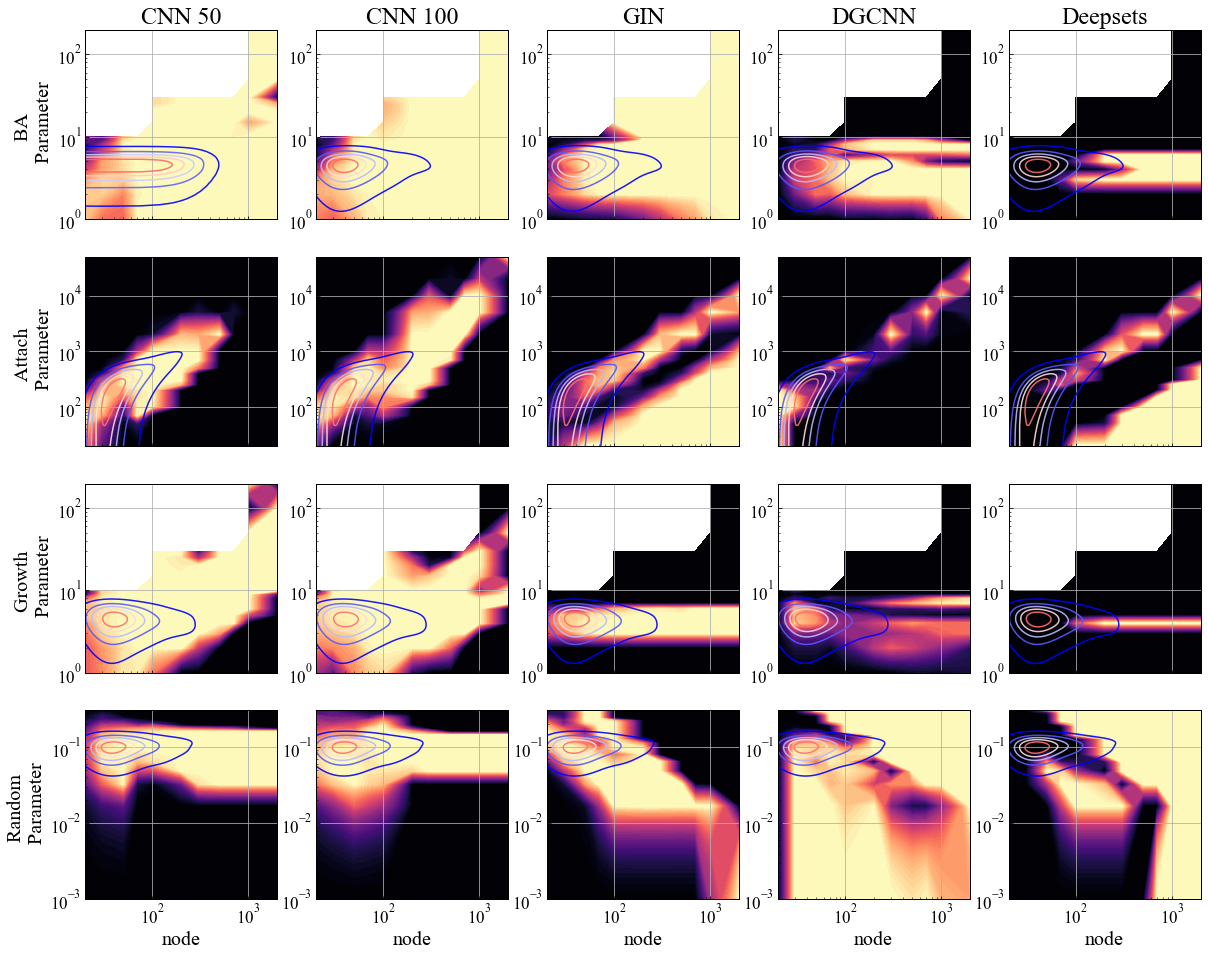

In [4]:
fig, axes  = plt.subplots(4, 5, figsize=(20, 16), sharex=True, sharey=False)
data = "new_parete"
plot_contour(f"./robustness_plot/CNN_{data}_50.csv", axes, 0, f"CNN 50", data)
plot_contour(f"./robustness_plot/CNN_{data}_100.csv", axes, 1, f"CNN 100", data)
plot_contour(f"./robustness_plot/GNN/GIN_{data}_49_0.csv", axes, 2, f"GIN", data)
plot_contour(f"./robustness_plot/GNN/DGCNN_{data}_49_0.csv", axes, 3, f"DGCNN", data)
plot_contour(f"./robustness_plot/GNN/Deepsets_{data}_49_0.csv", axes, 4, f"Deepsets", data)

plt.savefig("./robustness_plot/new_sample.png")

In [69]:

def make_edge_bins(kind):
    pred_df = pd.read_csv("./robustness_plot/CNN_new_poisson_100.csv")
    pred_df.drop(["Unnamed: 0"], axis=1, inplace=True)
    # network info df
    robustness_df = pd.read_csv("./robustness_plot/robustness_info.csv")
    robustness_df.drop("Unnamed: 0", axis=1, inplace=True)
    robustness_df.seed = robustness_df.seed.astype(int)
    # 結合(network info + prediction)
    merge_df = pd.merge(robustness_df, pred_df, on=["kind", "node", "parameter","seed"])
    merge_df = merge_df.query("edges>0")
    # 予測値が 0.9 以上のみの予測を採用
    lower_theres_index = merge_df[merge_df.probablility < .9].index
    merge_df.pred.loc[lower_theres_index] = [-1 for _ in range(len(lower_theres_index))]
    merge_df["correct"] = merge_df["true_label"] == merge_df["pred"] # 予測と
    # edge bins
    edges_bins = []
    for l in pd.cut(merge_df.edges, bins=np.logspace(0, math.log10(merge_df.edges.max())+1, num=15), include_lowest=True):
        edges_bins.append(float(l.mid))

    merge_df["edges_bins"] = edges_bins
    if kind is not None:
        merge_df = merge_df.query("kind==@kind")
    
    # grouping
    correct_total = merge_df.groupby(["node", "edges_bins"]).correct.count()
    df = pd.DataFrame(correct_sum / correct_total).reset_index()
    q_df = df.pivot_table(index="edges_bins", columns= "node", values="correct")
    return q_df

In [ ]:
path = "./robustness_plot/CNN_new_poisson_100.csv"
path = "./robustness_plot/GNN/GIN_new_poisson_49_0.csv"

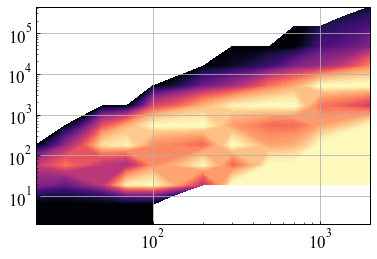

In [64]:
plt.contourf(q_df.columns, q_df.index, q_df.values,
                         cmap="magma", levels=50, vmin=0, vmax=1, alpha=1)
plt.xscale("log")
plt.yscale("log")

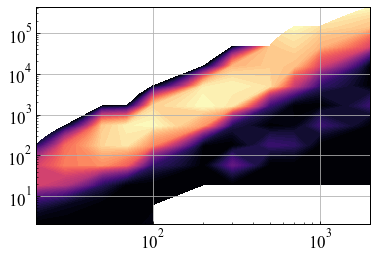

In [66]:
plt.contourf(q_df.columns, q_df.index, q_df.values,
                         cmap="magma", levels=50, vmin=0, vmax=1, alpha=1)
plt.xscale("log")
plt.yscale("log")

In [67]:
df = pd.read_csv("./robustness_plot/robustness_info.csv")

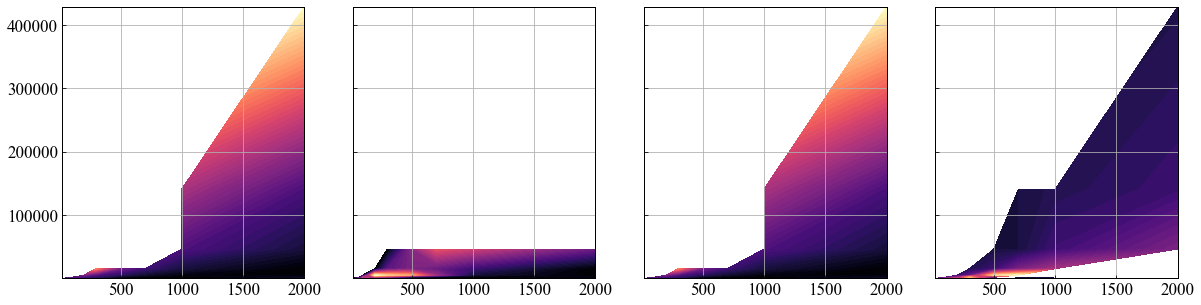

In [71]:
fig, axes = plt.subplots(1,4, figsize=(20,5), sharey=True)
for i, k in enumerate(["BA", "Attach", "Growth", "Random"]):
    kind_df = make_edge_bins(k)
    axes[i].contourf(kind_df.columns, kind_df.index, kind_df.values,
                         cmap="magma", levels=50, alpha=1)